In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
from sklearn.inspection import permutation_importance

import shap
from pathlib import Path
from modelling_pipeline import features
from joblib import dump, load
import matplotlib as mpl

plt.rcParams['figure.dpi'] = 150
%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['font.family'] = 'Optima'
mpl.rcParams['text.usetex'] = 'False'

In [30]:
def correlatePredictions(model, val_X, val_y, name):
    preds = model.predict(val_X)
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(preds, val_y, cmap=plt.cm.Spectral, s=7, edgecolor='k', lw=1)

    ax.set_xlabel('Predicted pay gap (%)',  **{ 'fontsize': 18})
    ax.set_ylabel('Actual pay gap (%)',  **{ 'fontsize': 18})
    ax.set_title(name,  **{ 'fontsize': 24})
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=False, labelsize=14)
    plt.tick_params(axis='x', which='both', labelleft=True, labelright=False, labelsize=14)
    plt.savefig('viz/{}-correlation.png'.format(name), dpi=150)
    plt.show()



def feature_importance(model, X, target_name):
    feature_importances = pd.DataFrame(
        model.feature_importances_,
        index=X.columns,
        columns=['importance']).sort_values('importance', ascending=False)
    fig, ax = plt.subplots(figsize=(7, 10))
    sns.barplot(ax=ax, data=feature_importances.reset_index(), 
                x='importance', 
                y='index', orient='h')
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=False, labelsize=14)
    plt.tick_params(axis='x', which='both', labelleft=True, labelright=False, labelsize=14)
    plt.savefig('viz/{}-fi.png'.format(target_name), dpi=150)
    plt.show()


def permutation_importance(model, X, y, target_name):
    perm = PermutationImportance(model, random_state=1).fit(X, y)
    eli5.show_weights(perm, feature_names=X.columns.tolist())
    plt.savefig('viz/{}-perm-imp.png'.format(target_name), dpi=150)
    plt.show()


def partial_dependence_plot(model, data, feature_names, feature_to_plot, target_name):
    pdp_score = pdp.pdp_isolate(model=model, dataset=data, model_features=feature_names,
                                feature=feature_to_plot)
    pdp.pdp_plot(pdp_score, feature_to_plot)
    pdp.plt.title('Partial dependence plot of {}'.format(feature_to_plot),  **{ 'fontsize': 24})
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=False, labelsize=18)
    plt.tick_params(axis='x', which='both', labelleft=True, labelright=False, labelsize=18)
    plt.xlabel([])
    pdp.plt.savefig('viz/{}-{}-pdp.png'.format(target_name, feature_to_plot), dpi=150)
    plt.show()


def plot_shap_values(model, X, target_name):
    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(model)
    # calculate shap values. This is what we will plot.
    # Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X)
    plt.savefig('viz/{}-shap.png'.format(target_name), dpi=150)
    plt.show()

def explain_model(target_name, X, y):
    model = load('models/{}-best-model.joblib'.format(target_name))
    correlatePredictions(model, X, y, target_name)
    partial_dependence_plot(model, X.sample(frac=0.05), features, 'RepresentationInLowerQuartileSkew' , target_name )
    partial_dependence_plot(model, X.sample(frac=0.05), features, 'RepresentationInTopQuartileSkew' , target_name )
    permutation_importance(model, X, y, target_name)
    feature_importance(model, X, target_name)
    plot_shap_values(model, X, target_name)
   




In [36]:
Path('viz').mkdir(parents=True, exist_ok=True)
df = pd.read_csv('data/holdout_data.csv')
#df = df.sample(frac=0.05)
X = df[features]
for target in ['DiffMeanHourlyPercent', 'DiffMedianHourlyPercent']:
    y = df[target].values
    explain_model(target, X, y)



Running a PI and shap separately for report

In [37]:
median_model = load('models/{}-best-model.joblib'.format('DiffMedianHourlyPercent'))
y = df['DiffMedianHourlyPercent'].values
perm = PermutationImportance(median_model, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names=X.columns.tolist())
# plt.savefig('viz/{}-perm-imp.png'.format('DiffMedianHourlyPercent'), dpi=150)
# plt.show()

Weight,Feature
0.2671 ± 0.0122,RepresentationInTopQuartileSkew
0.0351 ± 0.0069,RepresentationInLowerQuartileSkew
0.0335 ± 0.0053,SectP
0.0172 ± 0.0033,RepresentationInUpperMiddleQuartileSkew
0.0110 ± 0.0101,FirstSicCodeAsNum
0.0094 ± 0.0024,RepresentationInLowerMiddleQuartileSkew
0.0070 ± 0.0035,PercFemaleWorkforceInUpperMiddleQuartile
0.0046 ± 0.0006,SectO
0.0041 ± 0.0033,PercMaleWorkforceInLowerMiddleQuartile
0.0040 ± 0.0034,MaleTopQuartile


In [49]:
perm.feature_importances_

array([-4.52955389e-03, -6.52124968e-03,  3.27507572e-04, -2.55274123e-05,
        2.48326837e-05, -4.12541709e-04, -1.10572416e-03, -2.35612302e-04,
        3.97412565e-03, -4.58752338e-04, -1.69277180e-03, -1.31070191e-03,
        9.38002154e-03,  1.71737814e-02,  3.51020690e-02,  2.67130106e-01,
       -6.12961165e-03,  3.46024274e-03,  4.08337642e-03, -3.15934682e-03,
       -1.05437537e-02,  6.97864317e-03,  1.37486432e-03, -9.23354283e-03,
        4.28696248e-04, -2.68204803e-03, -3.44329075e-04, -6.75118037e-06,
       -7.16641010e-04,  1.49152692e-04, -5.04305388e-04, -1.52983013e-07,
        7.66434439e-05,  1.00683469e-04,  9.10005467e-04, -1.17543790e-04,
       -2.11838666e-06,  1.16647651e-03,  1.40048250e-04, -5.65671263e-05,
        2.57706515e-03, -6.19946292e-04,  1.39113365e-03, -1.07406483e-04,
        2.38716728e-03,  2.49482655e-04,  4.55124447e-03,  3.34703397e-02,
       -1.91674680e-03, -5.47427105e-04,  3.79651408e-06, -4.06318656e-07,
       -1.05221398e-02,  

In [56]:
pi = dict(zip(features, perm.feature_importances_))  

In [62]:
pi_sorted = {k: v for k, v in sorted(pi.items(), key=lambda item: item[1], reverse=True)}

In [63]:
pi_sorted

{'RepresentationInTopQuartileSkew': 0.26713010619757477,
 'RepresentationInLowerQuartileSkew': 0.035102068969606125,
 'SectP': 0.03347033967863,
 'RepresentationInUpperMiddleQuartileSkew': 0.017173781380955423,
 'FirstSicCodeAsNum': 0.01096806165925519,
 'RepresentationInLowerMiddleQuartileSkew': 0.009380021544114991,
 'PercFemaleWorkforceInUpperMiddleQuartile': 0.006978643169330811,
 'SectO': 0.004551244467218929,
 'PercMaleWorkforceInLowerMiddleQuartile': 0.004083376423142692,
 'MaleTopQuartile': 0.003974125646162219,
 'PercMaleWorkforceInUpperMiddleQuartile': 0.0034602427440056926,
 'SectI': 0.0025770651522378563,
 'SectM': 0.002387167284675229,
 'SectK': 0.0013911336490553873,
 'PercFemaleWorkforceInLowerMiddleQuartile': 0.001374864317876434,
 'SectF': 0.0011664765105293905,
 'SectC': 0.0009100054670918345,
 'year': 0.00042869624848527186,
 'MaleLowerQuartile': 0.0003275075723252918,
 'SectN': 0.00024948265494082464,
 'EmpSize500': 0.00014915269246615904,
 'SectG': 0.00014004824983

In [4]:
median_model = load('models/{}-best-model.joblib'.format('DiffMedianHourlyPercent'))

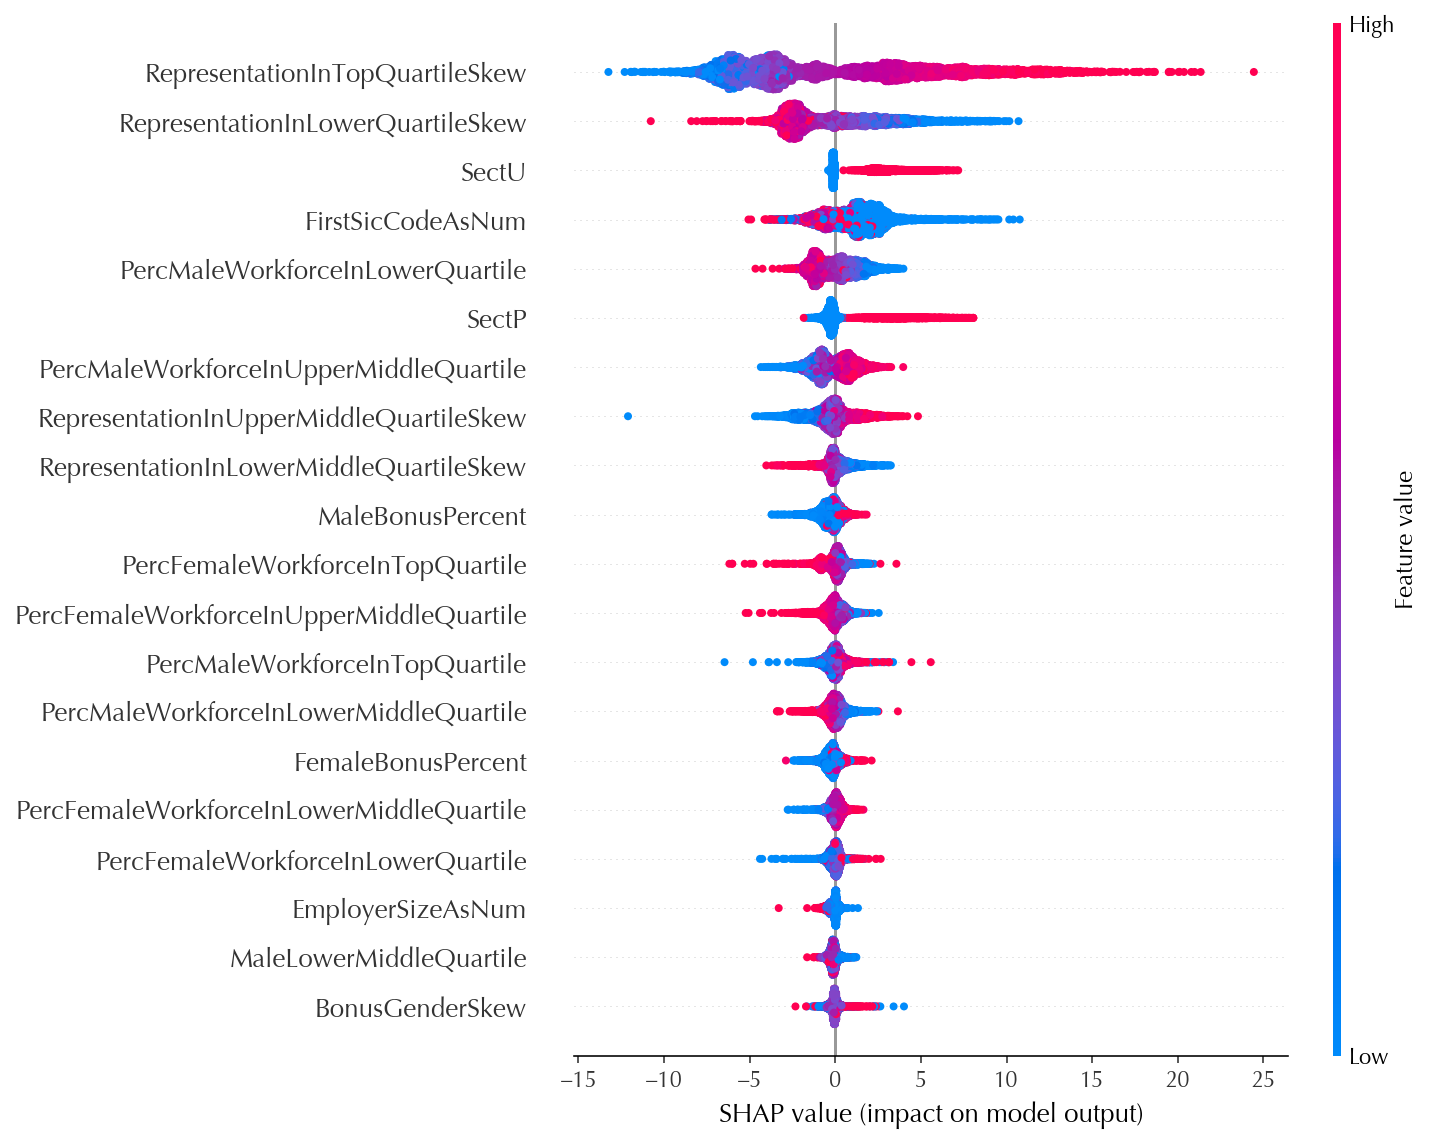

<Figure size 432x288 with 0 Axes>

In [9]:
plot_shap_values(median_model, X,'median')
